
### Marcenko-Pastur Law / Quarter Circle Law

http://math.mit.edu/~edelman/publications/random_matrix_theory_innovative.pdf


This time, I ensure W has norm 1


In [1]:
import numpy as np
import tensorflow as tf
import pickle, time
from copy import deepcopy
from shutil import copy
from tqdm import tqdm_notebook as tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
print(sklearn.__version__)

/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


0.19.1


In [2]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K


model = Sequential()
model.add(Conv2D(96, (5, 5), input_shape=(28, 28, 3), kernel_initializer=
                 'glorot_normal', bias_initializer=Constant(0.1), padding=
                 'same', activation='relu')) 
model.add(MaxPooling2D((3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (5, 5), kernel_initializer='glorot_normal',
                 bias_initializer=Constant(0.1), padding='same',
                 activation='relu')) 
model.add(MaxPooling2D((3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(384, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(192, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(10, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='softmax'))



sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())



Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [36]:
all_singular_values = []
all_0_vectors = []

all_bleeding_vectors = []
all_wigner_vectors = []

with tqdm(total=25) as pbar:
    for idx in range(1,26):
        modelfile = "weights/alexnet.b100.id{}.final.h5".format(idx)
        model.load_weights(modelfile)
        W = model.layers[7].get_weights()[0]
        n = 384
        W = W / np.linalg.norm(W)
        svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
        svd.fit(W) 
        sv = svd.singular_values_
        all_singular_values.extend(sv)
        all_0_vectors.append(svd.components_[0])
        
        for  val, vec in zip(sv, svd.components_):
            if (val) > 0.065:
                all_bleeding_vectors.append(vec)
            else:
                all_wigner_vectors.append(vec)
            

        pbar.update(1)


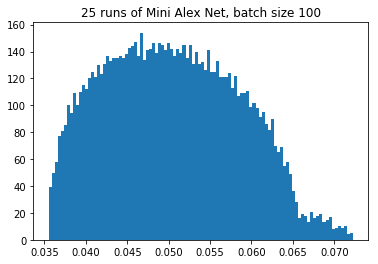

In [37]:
plt.hist(all_singular_values, bins=100);
plt.title(modelfile)
plt.title('25 runs of Mini Alex Net, batch size 100')
plt.show()


In [12]:
rand_singular_values = []
rand_0_vectors = []

rand_bleeding_vectors = []
rand_wigner_vectors = []

rand_bleeding_singular_values = []
rand_wigner_singular_values = []

with tqdm(total=25) as pbar:
    for idx in range(1,26):
        modelfile = "weights/alexnet.b100.rand100.id{}.final.h5".format(idx)
        model.load_weights(modelfile)
        W = model.layers[7].get_weights()[0]
        n = 384
        W = W / np.linalg.norm(W)
        svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
        svd.fit(W) 
        sv = svd.singular_values_
        rand_singular_values.extend(sv)
        rand_0_vectors.append(svd.components_[0])
        
        for  val, vec in zip(sv, svd.components_):
            if (val) > 0.068:
                rand_bleeding_vectors.append(vec)
                rand_bleeding_singular_values.append(val)

            else:
                rand_wigner_vectors.append(vec)
                rand_wigner_singular_values.append(val)
        pbar.update(1)

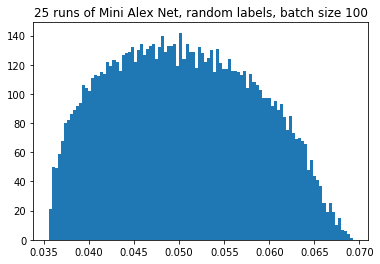

In [9]:
plt.hist(rand_singular_values, bins=100);
plt.title(modelfile)
plt.title("25 runs of Mini Alex Net, random labels, batch size 100")
plt.show()

In [10]:
len(rand_bleeding_singular_values), len(rand_singular_values), len(rand_wigner_singular_values)

(15, 9575, 9560)

In [37]:
len(all_singular_values), len(rand_singular_values)

(28725, 28725)

### Increasing Batch Size causes spikes to become bleeding out
#### Random label bleeding out is much weaker now

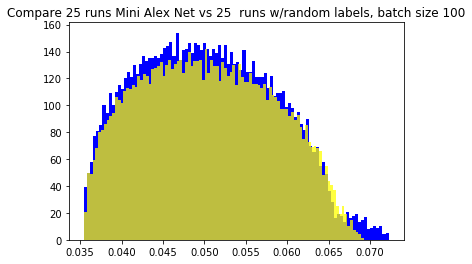

In [29]:
plt.hist(all_singular_values, bins=100, alpha=1.0, color='blue');
plt.hist(rand_singular_values, bins=100, alpha=0.75, color='yellow');
plt.title('Compare 25 runs Mini Alex Net vs 25  runs w/random labels, batch size 100')
plt.show()

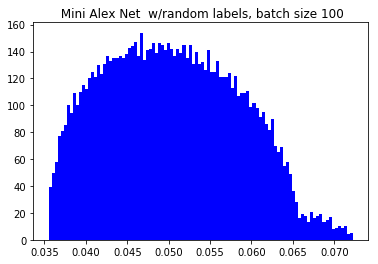

In [46]:
plt.hist(all_singular_values, bins=100, alpha=1.0, color='blue');
plt.title(' Mini Alex Net  w/random labels, batch size 100')
plt.show()

### Analysis of principle vectors in both normal and and  Rand 100

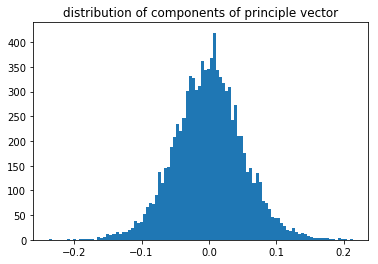

In [30]:
vec_comps = []
for vec in all_0_vectors:
    vec_comps.extend(vec)
plt.hist(vec_comps, bins=100);
plt.title('distribution of components of principle vector')

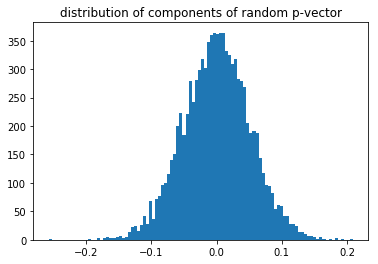

In [31]:
rand_comps = []
for vec in rand_0_vectors:
    rand_comps.extend(vec)
plt.hist(rand_comps, bins=100);
plt.title('distribution of components of random p-vector')

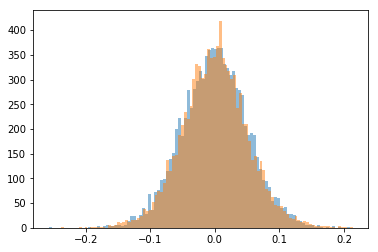

In [32]:
plt.hist(rand_comps, bins=100, alpha=0.5);
plt.hist(vec_comps, bins=100, alpha=0.5);


### Norms

In [38]:
all_norm_ratios = []
rand_norm_ratios = []

for vec in all_0_vectors:
    nr = np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)
    all_norm_ratios.append(nr)
    
for vec in rand_0_vectors:
    nr = np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)
    rand_norm_ratios.append(nr)
    

https://arxiv.org/pdf/1401.5093.pdf

### Compare Wigner circle to bleeding out (first 9)  eigenvectors

In [39]:
all_singular_values[0:10] 

[0.071261659,
 0.070166864,
 0.069318756,
 0.068610974,
 0.068383828,
 0.068103701,
 0.067940339,
 0.066955879,
 0.066329308,
 0.065681323]

In [35]:
rand_singular_values[0:10]

[0.068567358,
 0.067385651,
 0.066956721,
 0.066517897,
 0.066361167,
 0.065955542,
 0.065599926,
 0.065383263,
 0.06512519,
 0.065009043]

### Plot singular value vs norm ratio

In [40]:
bleeding_norm_ratios = []
wigner_norm_ratios = []
for vec in all_bleeding_vectors:
    nr = np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)
    bleeding_norm_ratios.append(nr)
    
for vec in all_wigner_vectors:
    nr = np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)
    wigner_norm_ratios.append(nr)

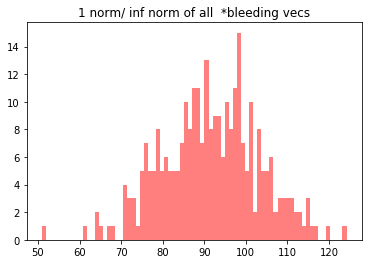

In [41]:
plt.hist(bleeding_norm_ratios, color='red', bins=75, alpha=0.5);

plt.title('1 norm/ inf norm of all  *bleeding vecs')

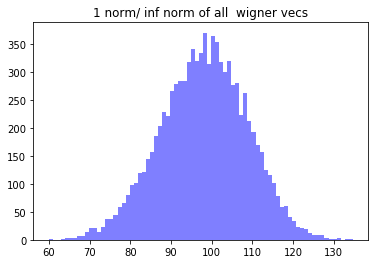

In [42]:
plt.hist(wigner_norm_ratios, color='blue', bins=75, alpha=0.5);
plt.title('1 norm/ inf norm of all  wigner vecs')

In [43]:
np.mean(bleeding_norm_ratios), np.mean(wigner_norm_ratios)

(91.50811, 98.086128)

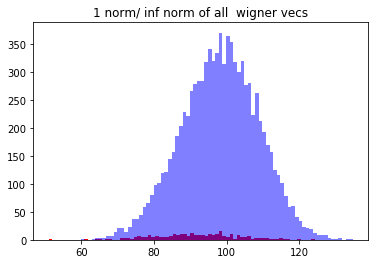

In [44]:
plt.hist(bleeding_norm_ratios, color='red', bins=75);
plt.hist(wigner_norm_ratios, color='blue', bins=75, alpha=0.5);
plt.title('1 norm/ inf norm of all  wigner vecs')

### Repeat for Random 100

In [53]:
rand_bleeding_norm_ratios = []
rand_wigner_norm_ratios = []
for vec in rand_bleeding_vectors:
    nr = np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)
    rand_bleeding_norm_ratios.append(nr)
    
for vec in rand_wigner_vectors:
    nr = np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)
    rand_wigner_norm_ratios.append(nr)

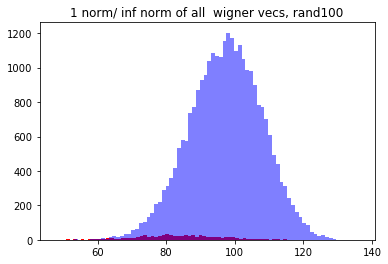

In [54]:
plt.hist(rand_bleeding_norm_ratios, color='red', bins=75);
plt.hist(rand_wigner_norm_ratios, color='blue', bins=75, alpha=0.5);
plt.title('1 norm/ inf norm of all  wigner vecs, rand100')

### Comparison of bledding out / shelf vectors rand 100 vs normal 

### NO DIFFERENCE 

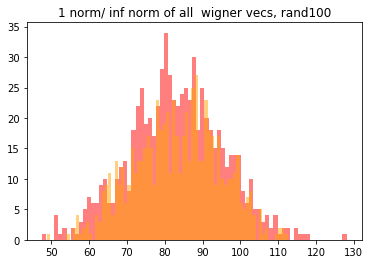

In [57]:
plt.hist(rand_bleeding_norm_ratios, color='red', bins=75, alpha=0.5);
plt.hist(bleeding_norm_ratios, color='orange', bins=75, alpha=0.5);
plt.title('1 norm/ inf norm of all  wigner vecs, rand100')

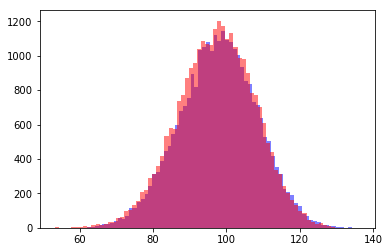

In [72]:
plt.hist(wigner_norm_ratios, color='blue', bins=75, alpha=0.5);
plt.hist(rand_wigner_norm_ratios, color='red', bins=75, alpha=0.5);


In [73]:
len(rand_bleeding_norm_ratios)

732

In [74]:
len(bleeding_norm_ratios)

675